In [1]:
# packages required for new environment
! pip install pandas
! pip install nltk
! pip install datasets
! pip install tqdm
! pip install ipywidgets
! pip install Pillow

In [8]:
#Libraries
import pandas as pd
import datasets
import nltk
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Dataset 1

In [3]:
# 1. tiny-imagenet
#   (a) Dataset Summary - Tiny ImageNet contains 100,000+ images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images, and 50 test images.
#   (b) Data Feature Dimensions -
#       i. Image: A PIL.Image.Image object containing the image.
#       ii. Label: an int classification label. -1 for the test set as the labels are missing. Check classes.py for the map of numbers and labels.

In [4]:
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')
random.seed(42)

In [5]:
# get all class id and label from words.txt
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

# load images to dataframe
def load_image(file_path):
    try:
        with Image.open(file_path) as img:
            return img.convert('RGB')
    except Exception as e:
        print(f"Error loading image from {file_path}: {e}")
        return None

In [6]:
# Training datset creation 
tiny_imagenet_train = pd.DataFrame()
for root, directories, files in os.walk(TRAIN_DIR):
    for directory in directories:
        d = pd.read_csv(os.path.join(root,directory, directory + "_boxes.txt"), 
                       sep='\t', 
                       header=None, 
                       names=['File', 'X', 'Y', 'H', 'W'])
        tiny_imagenet_train = pd.concat([tiny_imagenet_train,d])
    break
tiny_imagenet_train["Class"]=tiny_imagenet_train.apply(lambda row: row.File.split('_')[0], axis=1)
tiny_imagenet_train.File=tiny_imagenet_train.apply(lambda row: load_image(os.path.join(root, row.Class ,"images", row.File)), axis=1)
tiny_imagenet_train['label']=tiny_imagenet_train.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_train = tiny_imagenet_train.sample(frac=1).reset_index(drop=True)
tiny_imagenet_train

,File,X,Y,H,W,Class,label
0,<PIL.Image.Image image mode=RGB size=64x64 at ...,0,25,63,33,n04275548,spider web
1,<PIL.Image.Image image mode=RGB size=64x64 at ...,12,0,54,63,n04532106,vestment
2,<PIL.Image.Image image mode=RGB size=64x64 at ...,0,10,63,63,n02233338,cockroach
3,<PIL.Image.Image image mode=RGB size=64x64 at ...,0,1,19,40,n03400231,frying pan
4,<PIL.Image.Image image mode=RGB size=64x64 at ...,35,26,63,50,n02165456,ladybug
...,...,...,...,...,...,...,...
99995,<PIL.Image.Image image mode=RGB size=64x64 at ...,0,3,63,55,n02892201,brass
99996,<PIL.Image.Image image mode=RGB size=64x64 at ...,28,1,56,63,n04562935,water tower
99997,<PIL.Image.Image image mode=RGB size=64x64 at ...,3,3,33,63,n03544143,hourglass
99998,<PIL.Image.Image image mode=RGB size=64x64 at ...,0,1,63,63,n04067472,reel


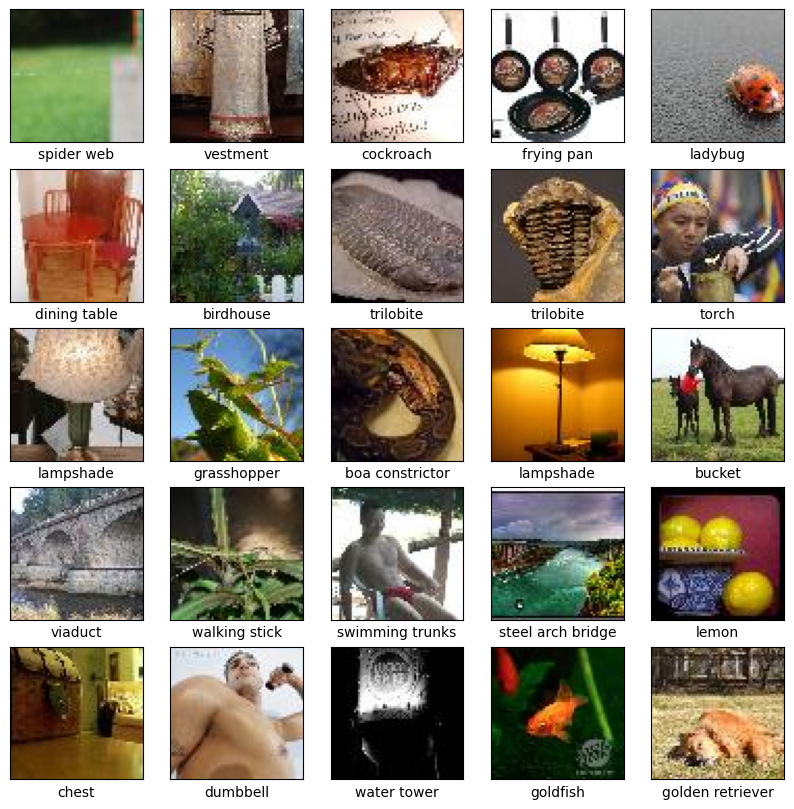

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tiny_imagenet_train.iloc[i].File)
    plt.xlabel(tiny_imagenet_train.iloc[i].label)
plt.show()

In [10]:
# Validation dataset creation 

# Display first 20 entries of resulting dictionary
# {k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}
tiny_imagenet_valid = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

# tiny_imagenet_valid.head()
# attaching label to respective class 
tiny_imagenet_valid["label"] = tiny_imagenet_valid.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_valid.File=tiny_imagenet_valid.apply(lambda row: load_image(os.path.join(VALID_DIR,"images", row.File)), axis=1)
tiny_imagenet_valid = tiny_imagenet_valid.sample(frac=1).reset_index(drop=True)
tiny_imagenet_valid

,File,Class,X,Y,H,W,label
0,<PIL.Image.Image image mode=RGB size=64x64 at ...,n04501370,50,33,63,63,turnstile
1,<PIL.Image.Image image mode=RGB size=64x64 at ...,n03937543,16,0,54,30,pill bottle
2,<PIL.Image.Image image mode=RGB size=64x64 at ...,n02504458,3,28,52,57,African elephant
3,<PIL.Image.Image image mode=RGB size=64x64 at ...,n02481823,28,13,63,63,chimpanzee
4,<PIL.Image.Image image mode=RGB size=64x64 at ...,n07871810,0,0,63,59,meat loaf
...,...,...,...,...,...,...,...
9995,<PIL.Image.Image image mode=RGB size=64x64 at ...,n01774750,20,18,63,48,tarantula
9996,<PIL.Image.Image image mode=RGB size=64x64 at ...,n03649909,9,29,47,51,lawn mower
9997,<PIL.Image.Image image mode=RGB size=64x64 at ...,n02437312,18,13,63,50,Arabian camel
9998,<PIL.Image.Image image mode=RGB size=64x64 at ...,n03976657,0,12,63,34,pole


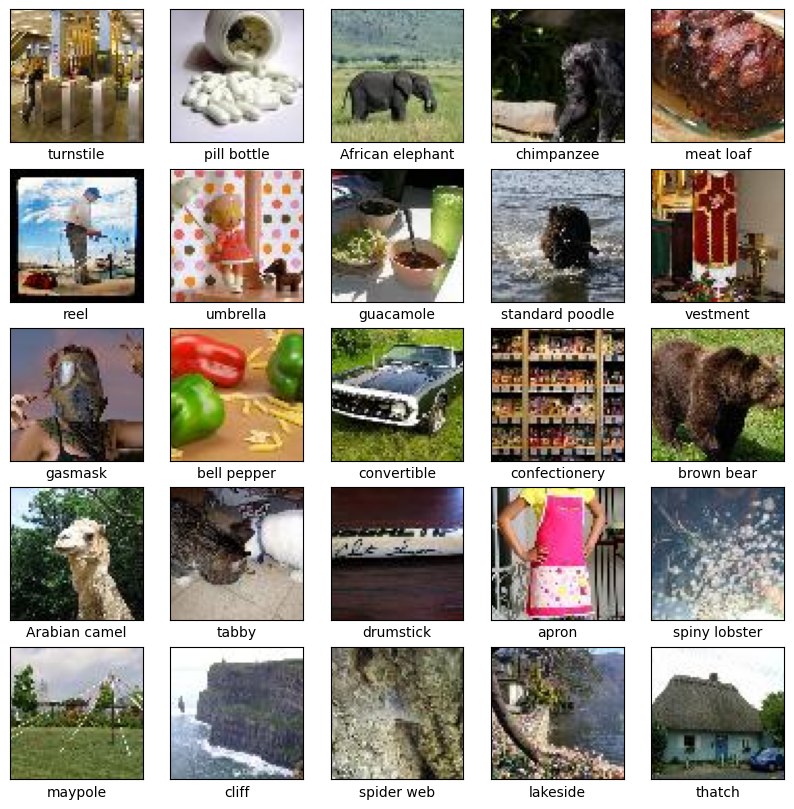

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tiny_imagenet_valid.iloc[i].File)
    plt.xlabel(tiny_imagenet_valid.iloc[i].label)
plt.show()

# Regularization Techniques for Dataset 1

In [ ]:
# 1. L2 Regularization - modifies the loss function. Applied to both datasets.
# 2. Data Augmentation - modifies the data. For Dataset1 we plan to use RandomErasing
#              - RandomErasing is concerned about removing and randomly adding information on the
#               blank space, such as noise. For Dataset2 we plan to use Random Synonym Replacement -
#               Random Synonym Replacement is concerned about removing and replacing with a synonym.
# 3. MaxDropout - modifies training approach. Applied to both datasets.
# 4. Ensemble Regularization 1 - applying RandomErasing and MaxDropout together. Applied to Dataset1.

# Dataset 2

In [ ]:
# 2. nltk-brown + nltk-treebank + nltk-conll2000
#   (a) Dataset Summary - The combination of these 3 datasets gives us a large corpus of
#                       textual data that can be used for training a model that performs sequence labeling with
#                       a total size of 72,000+ tagged sentences. The nltk library takes the base dataset and
#                       performs tokenization to prepare it for the task of sequence labeling.
#   (b) Data Feature Dimensions -
#         i. Input Sequence - A sentence in english.
#        ii. Output Sequence - POS tags of each word of the sentence.

In [ ]:
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('universal_tagset')


In [ ]:
treebank = treebank.tagged_sents(tagset='universal')
brown = brown.tagged_sents(tagset='universal')
conll2000 = conll2000.tagged_sents(tagset='universal')
print(treebank[0])
print(brown[0])
print(conll2000[0])

In [ ]:
def create_dataset(data):
    sentences = []
    pos_tags = []

    for sequence in data:
        sentence = []
        tags = []
        for seq in sequence:         
            sentence.append(seq[0])
            tags.append(seq[1])
            
        sentences.append(sentence)
        pos_tags.append(tags)
    return pd.DataFrame(zip(sentences, pos_tags), columns=["sentences", "pos_tags"])

In [ ]:
corpus_dataset = create_dataset(treebank + brown + conll2000)
corpus_dataset.head(5)

# Regularization Techniques for Dataset 2

In [ ]:
# 1. L2 Regularization - modifies the loss function. Applied to both datasets.
# 2. Data Augmentation - modifies the data. For Dataset1 we plan to use RandomErasing
#       - RandomErasing is concerned about removing and randomly adding information on the
#         blank space, such as noise. For Dataset2 we plan to use Random Synonym Replacement -
#         Random Synonym Replacement is concerned about removing and replacing with a synonym.
# 3. MaxDropout - modifies training approach. Applied to both datasets.
# 4. Ensemble Regularization 2 - applying RandomSynonymReplacement and MaxDropout together. Applied to Dataset2.